## 每日动量回测

#### 导入需要的库

In [31]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from datetime import datetime

#### 寻找 results 目录

In [32]:
# —— 可靠的 results 定位 + 保存代码（直接粘贴运行） ——
from pathlib import Path
import os

# 1) 自动寻找已有的 results 目录（从 cwd 向上查找）
def find_results_dir(start: Path = Path.cwd()) -> Path:
    if (start / "results").is_dir():
        return start / "results"
    for p in start.parents:
        if (p / "results").is_dir():
            return p / "results"
    # 找不到就返回 cwd/results（后面会创建）
    return start / "results"

results_dir = find_results_dir()
results_dir.mkdir(parents=True, exist_ok=True)  # 确保存在

print("当前工作目录 (cwd):", Path.cwd())
print("选定的 results 目录:", results_dir)
print("results 目录存在且可写?:", os.access(results_dir, os.W_OK))

当前工作目录 (cwd): c:\Users\Lenovo\Desktop\金融\量化\20250829_日频动量策略_on_SPY\momentum-demo\notebooks
选定的 results 目录: c:\Users\Lenovo\Desktop\金融\量化\20250829_日频动量策略_on_SPY\momentum-demo\results
results 目录存在且可写?: True


#### 设置全局参数

In [33]:
TICKER = "SPY"            # 标的，示例用 SPY（美股标准 ETF）
START = "2022-01-01"      # 起始日（改成近 3 年）
END = datetime.today().strftime("%Y-%m-%d")
WINDOW = 20               # 动量窗口（20 日）
TRADING_DAYS = 252        # 年化换算系数

#### 拉取数据

In [34]:
# 从Yahoo Finance上拉取数据
df = yf.download(TICKER, start=START, end=END, progress=False)
if df.empty: # type: ignore
    print("没有下载到数据。请检查 ticker / 日期范围 / 网络。")
    sys.exit(1)

    # 我们只用 Close 列
if 'Close' not in df.columns: # type: ignore
    print("数据中没有 'Close' 列，无法继续。Columns:", df.columns) # type: ignore
    sys.exit(1)

df = df[['Close']].dropna() # type: ignore
# 确保按时间升序
df.sort_index(inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_28280\396339770.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START, end=END, progress=False)


In [35]:
print("样本行数：", len(df)) # type: ignore
print("样本时间范围:", df.index.min(), "->", df.index.max()) # type: ignore

样本行数： 918
样本时间范围: 2022-01-03 00:00:00 -> 2025-08-29 00:00:00


#### 计算信号 (简单动量)

In [36]:
# 计算过去 WINDOW 天的收益率（收盘价比）
df['mom'] = df['Close'].pct_change(WINDOW) # type: ignore
# 信号：过去 WINDOW 天收益率 > 0 则持有（1），否则空仓（0）
df['signal'] = (df['mom'] > 0).astype(int) # type: ignore
# 我们避免未来函数（用今天的 signal 去决定明天的持仓）
df['signal_shift'] = df['signal'].shift(1).fillna(0).astype(int) # type: ignore

---

#### 1）不考虑交易成本

##### 每日回报 

In [37]:
df['ret_daily'] = df['Close'].pct_change().fillna(0) # type: ignore
# 策略回报（简单：无杠杆、全仓/空仓）
df['strat_ret'] = df['signal_shift'] * df['ret_daily'] # type: ignore

##### 累计净值

In [38]:
df['wealth_market'] = (1 + df['ret_daily']).cumprod() # type: ignore
df['wealth_strategy'] = (1 + df['strat_ret']).cumprod() # type: ignore

##### 绩效指标

In [39]:
n_days = len(df) # type: ignore
try:
    cumulative_return = df['wealth_strategy'].iloc[-1] - 1 # type: ignore
except IndexError:
    cumulative_return = np.nan

# 更稳妥的年化收益（基于日收益的几何平均）
if n_days > 0 and not df['strat_ret'].isna().all(): # type: ignore
    annualized_return = np.expm1(df['strat_ret'].mean() * TRADING_DAYS) # type: ignore
else:
    annualized_return = np.nan

# 年化波动，明确 ddof（这里选 ddof=0）
ann_vol = df['strat_ret'].std(ddof=0) * np.sqrt(TRADING_DAYS) if n_days > 0 else np.nan # type: ignore
sharpe = (annualized_return / ann_vol) if (ann_vol and not np.isnan(ann_vol)) else np.nan

In [40]:
print("累计收益 (strategy):", f"{cumulative_return:.2%}" if not np.isnan(cumulative_return) else "nan")
print("年化收益:", f"{annualized_return:.2%}" if not np.isnan(annualized_return) else "nan")
print("年化波动:", f"{ann_vol:.2%}" if not np.isnan(ann_vol) else "nan")
print("夏普指数Sharpe (rf=0):", f"{sharpe:.2f}" if not np.isnan(sharpe) else "nan")

累计收益 (strategy): 52.43%
年化收益: 12.95%
年化波动: 11.03%
夏普指数Sharpe (rf=0): 1.17


##### 最大回撤

In [41]:
rolling_max = df['wealth_strategy'].cummax() # type: ignore
drawdown = (df['wealth_strategy'] / rolling_max) - 1 # type: ignore
max_drawdown = drawdown.min()

In [42]:
print("最大回撤:", f"{max_drawdown:.2%}" if not np.isnan(max_drawdown) else "nan")

最大回撤: -11.00%


##### 胜率 & 交易次数

In [43]:
# 交易次数与胜率（更明确的计算）
transitions = int((df['signal_shift'] != df['signal_shift'].shift(1)).sum())  # type: ignore # 包含从 NaN->value 的变化
# 交易次数的定义：若想把一次完整的开仓+平仓算作 1，使用 transitions // 2
trade_days = transitions // 2  # type: ignore # 粗略估计换仓次数
position_days = int((df['signal_shift'] != 0).sum()) # type: ignore
win_rate = (df.loc[df['strat_ret'] > 0, 'strat_ret'].count() / position_days) if position_days > 0 else np.nan # type: ignore

In [44]:
print("交易次数:", trade_days)
print("持仓天数:", position_days)
print("胜率（持仓期间的正日收益占比）: {:.2%}".format(win_rate))

交易次数: 30
持仓天数: 571
胜率（持仓期间的正日收益占比）: 55.17%


##### 保存结果

In [45]:
try:
    df.to_csv(results_dir / "daily_results_no_tc.csv", index=True) # type: ignore
    pd.DataFrame({
        'metric': ['n_days', 'cumulative_return', 'annualized_return', 'annualized_vol', 'sharpe', 'max_drawdown', 'trade_days', 'win_rate'],
        'value': [n_days, cumulative_return, annualized_return, ann_vol, sharpe, max_drawdown, trade_days, win_rate]
    }).to_csv(results_dir / "summary_metrics_no_tc.csv", index=False)
except (OSError, PermissionError) as e:
    print("写入 results 失败：", e)
    raise

##### 绘制折线图：动量策略 VS 市场基准

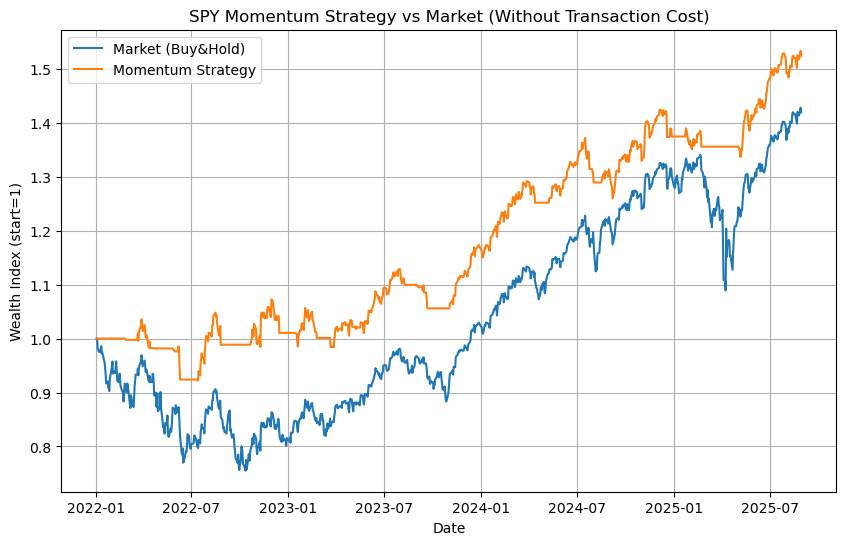

In [46]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['wealth_market'], label='Market (Buy&Hold)') # type: ignore
plt.plot(df.index, df['wealth_strategy'], label='Momentum Strategy') # type: ignore
plt.legend()
plt.title(f"{TICKER} Momentum Strategy vs Market (Without Transaction Cost)")
plt.ylabel("Wealth Index (start=1)")
plt.xlabel("Date")
plt.grid(True)
plt.savefig(results_dir / "performance_no_tc.png", dpi=150)
plt.show()
plt.close()

#### 2) 考虑交易成本

##### 每日回报

In [47]:
# 每次换仓时扣 transaction cost（简单模型）
tc = 0.0005
df['trade'] = df['signal_shift'].diff().abs()  # type: ignore # 1 表示换仓
df['strat_ret_net'] = df['strat_ret'] - df['trade'] * tc # type: ignore
# 然后用 strat_ret_net 计算 wealth

##### 累计净值

In [48]:
df['wealth_market'] = (1 + df['ret_daily']).cumprod() # type: ignore
df['wealth_strategy_net'] = (1 + df['strat_ret_net']).cumprod() # type: ignore

##### 绩效指标

In [49]:
n_days = len(df) # type: ignore
try:
    cumulative_return_net = df['wealth_strategy_net'].iloc[-1] - 1 # type: ignore
except IndexError:
    cumulative_return_net = np.nan

# 更稳妥的年化收益（基于日收益的几何平均）
if n_days > 0 and not df['strat_ret_net'].isna().all(): # type: ignore
    annualized_return_net = np.expm1(df['strat_ret_net'].mean() * TRADING_DAYS) # type: ignore
else:
    annualized_return_net = np.nan

# 年化波动，明确 ddof（这里选 ddof=0）
ann_vol_net = df['strat_ret_net'].std(ddof=0) * np.sqrt(TRADING_DAYS) if n_days > 0 else np.nan # type: ignore
sharpe_net = (annualized_return_net / ann_vol_net) if (ann_vol_net and not np.isnan(ann_vol_net)) else np.nan


In [50]:
print("净累计收益 (strategy): {:.2%}".format(cumulative_return_net))
print("净年化收益: {:.2%}".format(annualized_return_net))
print("净年化波动: {:.2%}".format(ann_vol_net))
print("净夏普指数Sharpe (rf=0): {:.2f}".format(sharpe_net))

净累计收益 (strategy): 47.99%
净年化收益: 12.06%
净年化波动: 11.04%
净夏普指数Sharpe (rf=0): 1.09


##### 最大回撤

In [51]:
rolling_max_net = df['wealth_strategy_net'].cummax() # type: ignore
max_drawdown_net = (df['wealth_strategy_net'] / rolling_max_net - 1).min() # type: ignore

In [52]:
print("净最大回撤:", f"{max_drawdown_net:.2%}" if not np.isnan(max_drawdown_net) else "nan")

净最大回撤: -11.36%


##### 胜率 & 交易次数

In [53]:
trade_days = transitions // 2  # type: ignore # 粗略估计换仓次数
win_rate_net = (df.loc[df['strat_ret_net'] > 0, 'strat_ret_net'].count()) / (df.loc[df['signal_shift'] != 0, 'strat_ret_net'].count()+1e-9) # type: ignore

In [54]:
print("交易次数（transitions）:", trade_days)
print("持仓天数:", position_days)
print("净胜率（持仓期间的正日收益占比）: {:.2%}".format(win_rate_net))

交易次数（transitions）: 30
持仓天数: 571
净胜率（持仓期间的正日收益占比）: 54.99%


##### 保存结果

In [55]:
df.to_csv(results_dir / "daily_results_tc.csv", index=True) # type: ignore
pd.DataFrame({
    'metric': ['n_days', 'cumulative_return', 'annualized_return', 'annualized_vol', 'sharpe', 'max_drawdown', 'trade_days', 'win_rate'],
    'value': [n_days, cumulative_return, annualized_return, ann_vol, sharpe, max_drawdown, trade_days, win_rate]
}).to_csv(results_dir / "summary_metrics_tc.csv", index=False)

##### 绘制折线图：动量策略 VS 市场基准

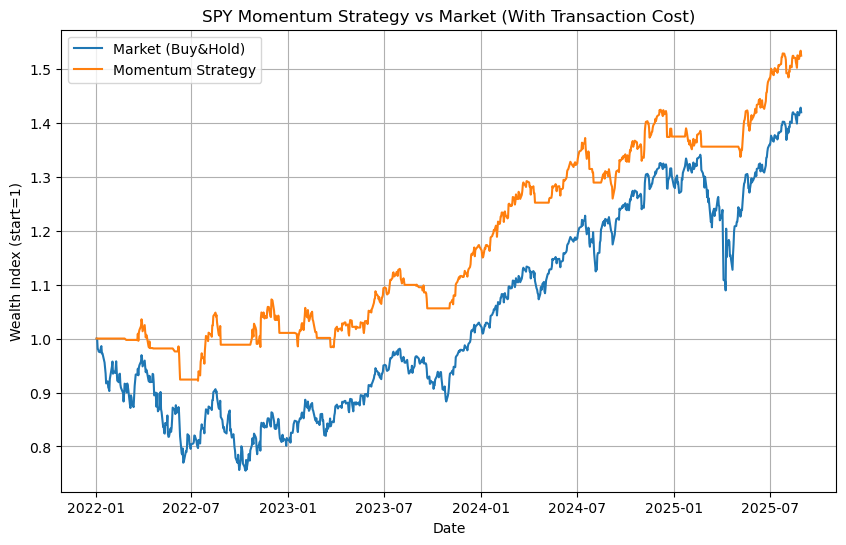

In [56]:
plt.figure(figsize=(10,6))
plt.plot(df.index, df['wealth_market'], label='Market (Buy&Hold)') # type: ignore
plt.plot(df.index, df['wealth_strategy'], label='Momentum Strategy') # type: ignore
plt.legend()
plt.title(f"{TICKER} Momentum Strategy vs Market (With Transaction Cost)")
plt.ylabel("Wealth Index (start=1)")
plt.xlabel("Date")
plt.grid(True)
plt.savefig(results_dir / "performance_tc.png", dpi=150)
plt.show()
plt.close()

---

#### 比较不考虑交易成本和考虑交易成本的结果

In [57]:
print("交易次数（transitions）:", trade_days)
print("持仓天数:", position_days)

print("\n")
print("不考虑交易成本：")
print("累计收益 (strategy):", f"{cumulative_return:.2%}" if not np.isnan(cumulative_return) else "nan")
print("年化收益:", f"{annualized_return:.2%}" if not np.isnan(annualized_return) else "nan")
print("年化波动:", f"{ann_vol:.2%}" if not np.isnan(ann_vol) else "nan")
print("夏普指数Sharpe (rf=0):", f"{sharpe:.2f}" if not np.isnan(sharpe) else "nan")
print("最大回撤:", f"{max_drawdown:.2%}" if not np.isnan(max_drawdown) else "nan")
print("胜率（持仓期间的正日收益占比）:", f"{win_rate:.2%}" if not np.isnan(win_rate) else "nan")

print()
print("考虑交易成本：")
print("净累计收益 (strategy):", f"{cumulative_return_net:.2%}" if not np.isnan(cumulative_return_net) else "nan")
print("净年化收益:", f"{annualized_return_net:.2%}" if not np.isnan(annualized_return_net) else "nan")
print("净年化波动:", f"{ann_vol_net:.2%}" if not np.isnan(ann_vol_net) else "nan")
print("净夏普指数Sharpe (rf=0):", f"{sharpe_net:.2f}" if not np.isnan(sharpe_net) else "nan")
print("净最大回撤:", f"{max_drawdown_net:.2%}" if not np.isnan(max_drawdown_net) else "nan")
print("净胜率（持仓期间的正日收益占比）:", f"{win_rate_net:.2%}" if not np.isnan(win_rate_net) else "nan")

交易次数（transitions）: 30
持仓天数: 571


不考虑交易成本：
累计收益 (strategy): 52.43%
年化收益: 12.95%
年化波动: 11.03%
夏普指数Sharpe (rf=0): 1.17
最大回撤: -11.00%
胜率（持仓期间的正日收益占比）: 55.17%

考虑交易成本：
净累计收益 (strategy): 47.99%
净年化收益: 12.06%
净年化波动: 11.04%
净夏普指数Sharpe (rf=0): 1.09
净最大回撤: -11.36%
净胜率（持仓期间的正日收益占比）: 54.99%


---

#### 考虑交易成本对动量策略的影响

In [58]:
def compute_metrics(df, ret_col, wealth_col, signal_col, trading_days=252):
    """返回指标字典：用于任意收益列与信号列"""
    n_days = len(df)
    # cumulative
    cumulative = df[wealth_col].iloc[-1] - 1
    # annualized (geometric)
    if n_days > 0:
        annualized = (1 + cumulative) ** (trading_days / n_days) - 1
    else:
        annualized = np.nan
    ann_vol = df[ret_col].std(ddof=0) * np.sqrt(trading_days) if n_days > 0 else np.nan
    sharpe = annualized / ann_vol if (ann_vol and not np.isnan(ann_vol)) else np.nan
    rolling_max = df[wealth_col].cummax()
    max_dd = (df[wealth_col] / rolling_max - 1).min()
    # trades / holding
    side_trades = int(df[signal_col].diff().abs().sum())
    round_trips = side_trades // 2
    holding_days = int((df[signal_col] != 0).sum())
    holding_pct = holding_days / n_days if n_days > 0 else np.nan
    # win rate (during holding)
    if df.loc[df[signal_col] != 0, ret_col].count() > 0:
        win_rate = df.loc[df[signal_col] != 0, ret_col].gt(0).mean()
    else:
        win_rate = np.nan

    return {
        "n_days": n_days,
        "cumulative_return": cumulative,
        "annualized_return": annualized,
        "annualized_vol": ann_vol,
        "sharpe": sharpe,
        "max_drawdown": max_dd,
        "side_trades": side_trades,
        "round_trips": round_trips,
        "holding_days": holding_days,
        "holding_pct": holding_pct,
        "win_rate": win_rate
    }

def to_pct(x):
    try:
        return f"{x:.2%}"
    except:
        return str(x)


In [59]:
# 交易成本（单边），可调
tc = 0.0005  # 0.05% 单边成本
# 成本感知开仓/平仓阈值（可调）
open_threshold = 2 * tc   # 开仓阈值：只有当动量 > round-trip 成本时才考虑开仓
close_threshold = 0.0     # 平仓阈值：当动量 <= close_threshold 时离场

In [60]:
# ----------------- 把交易成本直接扣在换仓日，得到原始策略的净收益（信号不变） -------------
df['trade_side_raw'] = df['signal_shift'].diff().abs().fillna(0) # type: ignore
df['strat_ret_net'] = df['strat_ret'] - df['trade_side_raw'] * tc # type: ignore
df['wealth_strategy_net'] = (1 + df['strat_ret_net']).cumprod() # type: ignore

# ----------------- 成本感知信号（门槛 + 滞后/hysteresis） -----------------
mom_arr = df['mom'].to_numpy()   # type: ignore # numpy array of floats (with np.nan)
sig_ca = np.zeros(len(mom_arr), dtype=int)
prev = 0
for i, mom_v in enumerate(mom_arr):
    # mom_v 是 numpy.float 或 np.nan, np.isnan 能安全使用
    if np.isnan(mom_v):
        sig_ca[i] = prev
        continue
    if prev == 0:
        # 未持仓，判断是否开仓（动量需超过阈值）
        sig_ca[i] = 1 if mom_v > open_threshold else 0
    else:
        # 已持仓，判断是否平仓
        sig_ca[i] = 0 if mom_v <= close_threshold else 1
    prev = sig_ca[i]

df['signal_costaware'] = pd.Series(sig_ca, index=df.index) # type: ignore
# 执行时延：用前一天 cost-aware 信号决定当日持仓
df['signal_cost_shift'] = df['signal_costaware'].shift(1).fillna(0) # type: ignore

# ----------------- 成本感知策略回测（毛/净） -----------------
df['strat_ret_ca'] = df['signal_cost_shift'] * df['ret_daily'] # type: ignore
df['trade_side_ca'] = df['signal_cost_shift'].diff().abs().fillna(0) # type: ignore
df['strat_ret_ca_net'] = df['strat_ret_ca'] - df['trade_side_ca'] * tc # type: ignore
df['wealth_strategy_ca'] = (1 + df['strat_ret_ca']).cumprod() # type: ignore
df['wealth_strategy_ca_net'] = (1 + df['strat_ret_ca_net']).cumprod() # type: ignore



=== 对比总结 ===
样本行数: 918  时间区间: 2022-01-03 00:00:00 -> 2025-08-29 00:00:00

-- 原始策略（gross） --
累计收益: 52.43% 年化: 12.27% Sharpe: 1.11
最大回撤: -11.00% 换手(side_trades): 59 round-trips: 29
持仓天数: 571 (62.20%) 胜率: 55.17%

-- 原始策略（net, after tc=0.0500%) --
累计收益: 47.99% 年化: 11.36% Sharpe: 1.03
最大回撤: -11.36% 换手(side_trades): 59 round-trips: 29
持仓天数: 571 (62.20%) 胜率: 54.99%

-- 成本感知策略（gross） --
累计收益: 54.51% 年化: 12.69% Sharpe: 1.15
最大回撤: -11.00% 换手(side_trades): 55 round-trips: 27
持仓天数: 568 (61.87%) 胜率: 55.28%

-- 成本感知策略（net, after tc=0.0500%) --
累计收益: 50.32% 年化: 11.84% Sharpe: 1.08
最大回撤: -11.36% 换手(side_trades): 55 round-trips: 27
持仓天数: 568 (61.87%) 胜率: 55.11%
对比CSV文件保存在： c:\Users\Lenovo\Desktop\金融\量化\20250829_日频动量策略_on_SPY\momentum-demo\results\summary_metrics_comparison.csv
对比折线图保存在： c:\Users\Lenovo\Desktop\金融\量化\20250829_日频动量策略_on_SPY\momentum-demo\results\performance_comparison.png


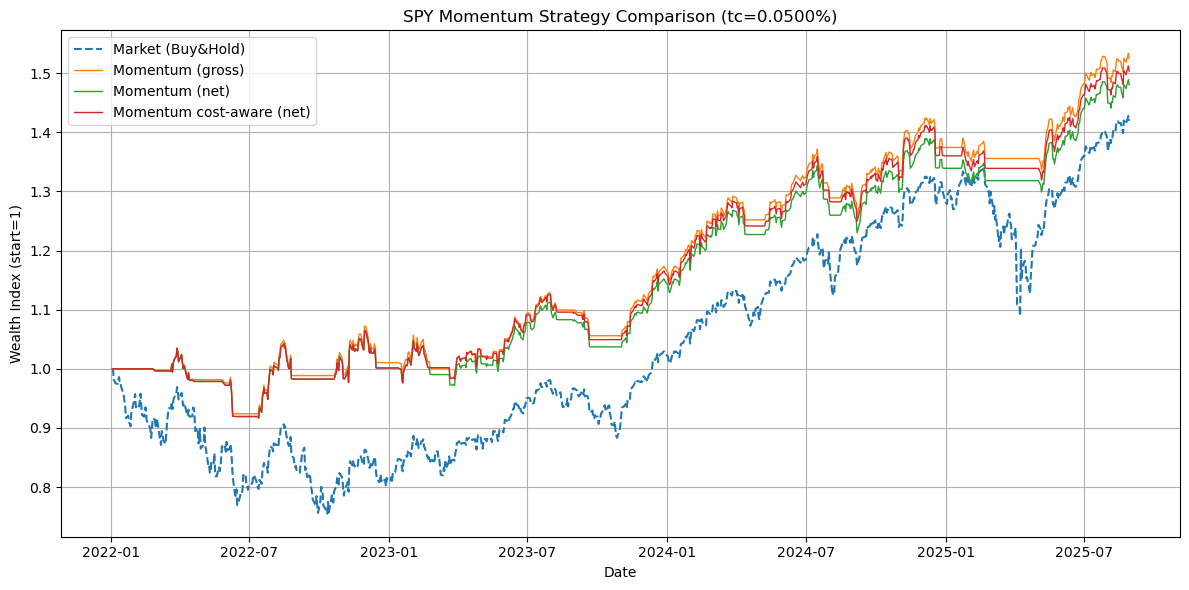

In [64]:
# ----------------- 计算各类指标 -----------------
metrics = {}
metrics['gross'] = compute_metrics(df, 'strat_ret', 'wealth_strategy', 'signal_shift', TRADING_DAYS)
metrics['gross']['market_cumulative'] = df['wealth_market'].iloc[-1] - 1
metrics['net'] = compute_metrics(df, 'strat_ret_net', 'wealth_strategy_net', 'signal_shift', TRADING_DAYS)
metrics['cost_aware_gross'] = compute_metrics(df, 'strat_ret_ca', 'wealth_strategy_ca', 'signal_cost_shift', TRADING_DAYS)
metrics['cost_aware_net'] = compute_metrics(df, 'strat_ret_ca_net', 'wealth_strategy_ca_net', 'signal_cost_shift', TRADING_DAYS)

# ----------------- 打印清晰对比（尽量保持你原来的输出格式） -----------------
print("\n=== 对比总结 ===")
print(f"样本行数: {metrics['gross']['n_days']}  时间区间: {df.index.min()} -> {df.index.max()}")
def p(x): return f"{x:.2%}" if (isinstance(x, (float, np.floating)) and not np.isnan(x)) else str(x)

print("\n-- 原始策略（gross） --")
print("累计收益:", p(metrics['gross']['cumulative_return']), "年化:", p(metrics['gross']['annualized_return']), "Sharpe:", f"{metrics['gross']['sharpe']:.2f}")
print("最大回撤:", p(metrics['gross']['max_drawdown']), "换手(side_trades):", p(metrics['gross']['side_trades']), "round-trips:", metrics['gross']['round_trips'])
print("持仓天数:", metrics['gross']['holding_days'], f"({metrics['gross']['holding_pct']:.2%})", "胜率:", p(metrics['gross']['win_rate']))

print("\n-- 原始策略（net, after tc={:.4%}) --".format(tc))
print("累计收益:", p(metrics['net']['cumulative_return']), "年化:", p(metrics['net']['annualized_return']), "Sharpe:", f"{metrics['net']['sharpe']:.2f}")
print("最大回撤:", p(metrics['net']['max_drawdown']), "换手(side_trades):", p(metrics['net']['side_trades']), "round-trips:", metrics['net']['round_trips'])
print("持仓天数:", metrics['net']['holding_days'], f"({metrics['net']['holding_pct']:.2%})", "胜率:", p(metrics['net']['win_rate']))

print("\n-- 成本感知策略（gross） --")
print("累计收益:", p(metrics['cost_aware_gross']['cumulative_return']), "年化:", p(metrics['cost_aware_gross']['annualized_return']), "Sharpe:", f"{metrics['cost_aware_gross']['sharpe']:.2f}")
print("最大回撤:", p(metrics['cost_aware_gross']['max_drawdown']), "换手(side_trades):", p(metrics['cost_aware_gross']['side_trades']), "round-trips:", metrics['cost_aware_gross']['round_trips'])
print("持仓天数:", metrics['cost_aware_gross']['holding_days'], f"({metrics['cost_aware_gross']['holding_pct']:.2%})", "胜率:", p(metrics['cost_aware_gross']['win_rate']))

print("\n-- 成本感知策略（net, after tc={:.4%}) --".format(tc))
print("累计收益:", p(metrics['cost_aware_net']['cumulative_return']), "年化:", p(metrics['cost_aware_net']['annualized_return']), "Sharpe:", f"{metrics['cost_aware_net']['sharpe']:.2f}")
print("最大回撤:", p(metrics['cost_aware_net']['max_drawdown']), "换手(side_trades):", p(metrics['cost_aware_net']['side_trades']), "round-trips:", metrics['cost_aware_net']['round_trips'])
print("持仓天数:", metrics['cost_aware_net']['holding_days'], f"({metrics['cost_aware_net']['holding_pct']:.2%})", "胜率:", p(metrics['cost_aware_net']['win_rate']))

# ----------------- 保存 daily results（包含所有列） -----------------
df.to_csv(results_dir / "daily_results_comparison.csv", index=True) # type: ignore
# 保存 summary 对比 CSV
summary_rows = []
for k, v in metrics.items():
    prefix = k
    for metric_name, val in v.items():
        summary_rows.append({
            "strategy": prefix,
            "metric": metric_name,
            "value": val
        })
summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(results_dir / "summary_metrics_comparison.csv", index=False)
print("对比CSV文件保存在：", results_dir / "summary_metrics_comparison.csv")

# ----------------- 绘图：市场、原始策略、成本感知策略（net） -------------
plt.figure(figsize=(12,6))
plt.plot(df.index, df['wealth_market'], label='Market (Buy&Hold)', linestyle='--', linewidth=1.5) # type: ignore
plt.plot(df.index, df['wealth_strategy'], label='Momentum (gross)', linewidth=1) # type: ignore
plt.plot(df.index, df['wealth_strategy_net'], label='Momentum (net)', linewidth=1) # type: ignore
plt.plot(df.index, df['wealth_strategy_ca_net'], label='Momentum cost-aware (net)', linewidth=1) # type: ignore
plt.legend()
plt.title(f"{TICKER} Momentum Strategy Comparison (tc={tc:.4%})")
plt.ylabel("Wealth Index (start=1)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.savefig(results_dir / "performance_comparison.png", dpi=150)
print("对比折线图保存在：", results_dir / "performance_comparison.png")
plt.show()
plt.close()